# Assignment 8: Data Aggregation and Group Operations

## Overview
This assignment covers data aggregation and group operations using healthcare/insurance EHR data. You'll analyze patient encounters (insurance claims), healthcare providers, and medical facilities across different regions. The data includes provider statistics, facility information, and encounter charges with insurance coverage details.

## Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seed for reproducibility
np.random.seed(42)

# Create output directory
os.makedirs("output", exist_ok=True)

## Question 1: Basic GroupBy Operations

### Part 1.1: Load and Explore Data

**TODO: Load and merge the datasets**

In [4]:
# TODO: Load the three CSV files into dataframes
provider_df = pd.read_csv("data/provider_data.csv")
facility_df = pd.read_csv("data/facility_data.csv")
encounter_df = pd.read_csv("data/encounter_data.csv")

# TODO: Print the shapes of each dataframe
print("Provider Data Shape:", provider_df.shape)
print("Facility Data Shape:", facility_df.shape)
print("Encounter Data Shape:", encounter_df.shape)

# TODO: Merge the dataframes for analysis
# Hint: Start by merging encounter_df with provider_df on 'provider_id'
#       Then merge the result with facility_df on 'facility_id'
# Note: Both encounter_df and provider_df have 'facility_id', and both encounter_df and facility_df have 'region'
#       After merging, you may need to handle duplicate column names (pandas will add suffixes like _x and _y)
#       You can drop one of the duplicate columns and rename if needed
merged_df = encounter_df.merge(
    provider_df, on="provider_id", how="left", suffixes=("", "_provider")
)

merged_df = merged_df.merge(
    facility_df, on="facility_id", how="left", suffixes=("", "_facility")
)

if "region_facility" in merged_df.columns:
    merged_df = merged_df.drop(columns=["region"]).rename(
        columns={"region_facility": "region"}
    )

if "facility_id_provider" in merged_df.columns:
    merged_df = merged_df.drop(columns=["facility_id_provider"])

# TODO: Print the merged dataframe shape, columns, and first few rows
print("\nMerged Data Shape:", merged_df.shape)

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
pd.set_option("display.max_colwidth", None)

print("\nColumns:", merged_df.columns.tolist())
print("\nFirst Few Rows:", (merged_df.head(10)))

Provider Data Shape: (500, 7)
Facility Data Shape: (10, 6)
Encounter Data Shape: (5000, 12)

Merged Data Shape: (5000, 21)

Columns: ['encounter_id', 'patient_id', 'provider_id', 'facility_id', 'encounter_date', 'encounter_type', 'diagnosis_code', 'procedure_code', 'service_charge', 'insurance_paid', 'patient_paid', 'provider_name', 'provider_type', 'specialty', 'years_experience', 'license_number', 'facility_name', 'facility_type', 'region', 'beds', 'established_date']

First Few Rows:   encounter_id patient_id provider_id facility_id encounter_date        encounter_type diagnosis_code  procedure_code  service_charge  insurance_paid  patient_paid     provider_name        provider_type         specialty  years_experience license_number              facility_name facility_type region  beds established_date
0     ENC00001   PAT01564      PR0259      FAC004     2023-08-21          Office Visit          M79.3           99213          345.03          290.33         54.70    Quinn Anderson  

### Part 1.2: Basic Aggregation

**TODO: Perform basic groupby operations**

In [5]:
# TODO: Group by facility (healthcare facility) and calculate basic stats
groupby_facility = merged_df.groupby("facility_name")

# TODO: Calculate mean, sum, count for years_experience by facility
facility_experience_stats = groupby_facility.agg(
    total_providers=("provider_id", "nunique"),  # ✅ unique provider count
    avg_years_experience=("years_experience", "mean"),
).reset_index()

# TODO: Calculate total encounter charges by facility
facility_charge_stats = (
    groupby_facility["service_charge"].agg(total_service_charge="sum").reset_index()
)

# TODO: Calculate total insurance payments by facility
facility_insurance_stats = (
    groupby_facility["insurance_paid"].agg(total_insurance_paid="sum").reset_index()
)

# TODO: Find the facility with highest total encounter charges
facility_highest_charge = facility_charge_stats.loc[
    facility_charge_stats["total_service_charge"].idxmax()
]

# TODO: Create a summary dataframe with one row per facility showing:
#       facility_name, total_providers, avg_years_experience, total_service_charge, total_insurance_paid
facility_summary_df = facility_experience_stats.merge(
    facility_charge_stats, on="facility_name"
).merge(facility_insurance_stats, on="facility_name")

# TODO: Save the summary dataframe as 'output/q1_groupby_analysis.csv'
facility_summary_df.to_csv("output/q1_groupby_analysis.csv", index=False)

# View results
print("\nFacility with Highest Total Encounter Charges:")
print(facility_highest_charge)

print("\nFacility Summary Dataframe:")
print(facility_summary_df.head(10))


Facility with Highest Total Encounter Charges:
facility_name           Pediatric Care Center
total_service_charge                361811.04
Name: 6, dtype: object

Facility Summary Dataframe:
                 facility_name  total_providers  avg_years_experience  total_service_charge  total_insurance_paid
0  Cardiology Specialty Center              297             19.319728             276658.83             222139.04
1        City General Hospital              312             19.563008             295508.13             236798.50
2      Community Health Clinic              328             20.160784             334992.21             269207.92
3     Emergency Medical Center              299             19.668687             310735.25             248439.20
4        Northside Urgent Care              305             20.137014             297283.06             236839.71
5    Oncology Treatment Center              324             19.381139             334927.30             267183.95
6        P

### Part 1.3: Transform Operations

**TODO: Use transform operations to add group statistics**

In [ ]:
# TODO: Add facility mean years_experience as new column
facility_summary_df = facility_summary_df.merge(
    facility_experience_stats[["facility_name", "avg_years_experience"]],
    on="facility_name",
    suffixes=("", "_mean"),
)

# TODO: Add facility standard deviation of years_experience
facility_experience_std = (
    groupby_facility["years_experience"].agg(std_years_experience="std").reset_index()
)

# TODO: Create normalized years_experience (z-score within facility)
facility_summary_df = facility_summary_df.merge(
    facility_experience_std, on="facility_name"
)

facility_summary_df["normalized_years_experience"] = (
    facility_summary_df["avg_years_experience"]
    - facility_summary_df["avg_years_experience_mean"]
) / facility_summary_df["std_years_experience"]

# TODO: Add facility total encounter charges as new column
facility_summary_df = facility_summary_df.merge(
    facility_charge_stats[["facility_name", "total_service_charge"]],
    on="facility_name",
    suffixes=("", "_total"),
)

# TODO: Display the enhanced dataframe
print("\nEnhanced Facility Summary Dataframe:")
print(facility_summary_df.head(10))

# TODO: Save results as 'output/q1_aggregation_report.txt'
with open("output/q1_aggregation_report.txt", "w", encoding="utf-8") as f:
    f.write("Assignment 8 — Question 1: Aggregation Report\n\n")
    f.write(facility_summary_df.to_string(index=False))


Enhanced Facility Summary Dataframe:
                 facility_name  total_providers  avg_years_experience  total_service_charge  total_insurance_paid  avg_years_experience_mean  std_years_experience  normalized_years_experience  total_service_charge_total
0  Cardiology Specialty Center              297             19.319728             276658.83             222139.04                  19.319728             10.484612                          0.0                   276658.83
1        City General Hospital              312             19.563008             295508.13             236798.50                  19.563008             10.702137                          0.0                   295508.13
2      Community Health Clinic              328             20.160784             334992.21             269207.92                  20.160784             11.044011                          0.0                   334992.21
3     Emergency Medical Center              299             19.668687             

## Question 2: Advanced GroupBy Operations

### Part 2.1: Filter Operations

**TODO: Use filter operations to remove groups**

In [7]:
# TODO: Filter facilities with more than 20 providers (sufficient staffing)
filtered_facilities = facility_summary_df[facility_summary_df["total_providers"] > 20]

# TODO: Filter facilities with average years_experience > 10 (experienced staff)
filtered_facilities = filtered_facilities[
    filtered_facilities["avg_years_experience"] > 10
]

# TODO: Filter facilities with total encounter charges > 250000 (high volume)
filtered_facilities = filtered_facilities[
    filtered_facilities["total_service_charge"] > 250000
]

# TODO: Create a summary of filtered results
filtered_summary_df = filtered_facilities.copy()

print("\nFiltered Facility Summary Dataframe:")
print(filtered_summary_df.head(10))

# TODO: Save results as 'output/q2_filter_analysis.csv'
filtered_summary_df.to_csv("output/q2_filter_analysis.csv", index=False)


Filtered Facility Summary Dataframe:
                 facility_name  total_providers  avg_years_experience  total_service_charge  total_insurance_paid  avg_years_experience_mean  std_years_experience  normalized_years_experience  total_service_charge_total
0  Cardiology Specialty Center              297             19.319728             276658.83             222139.04                  19.319728             10.484612                          0.0                   276658.83
1        City General Hospital              312             19.563008             295508.13             236798.50                  19.563008             10.702137                          0.0                   295508.13
2      Community Health Clinic              328             20.160784             334992.21             269207.92                  20.160784             11.044011                          0.0                   334992.21
3     Emergency Medical Center              299             19.668687             

### Part 2.2: Apply Operations

**TODO: Use apply operations with custom functions**

In [8]:
# TODO: Create custom function to calculate provider statistics
def provider_stats(group):
    # TODO: Return mean, std, min, max, range for years_experience
    stats = {
        "mean_years_experience": group["years_experience"].mean(),
        "std_years_experience": group["years_experience"].std(),
        "min_years_experience": group["years_experience"].min(),
        "max_years_experience": group["years_experience"].max(),
        "range_years_experience": group["years_experience"].max()
        - group["years_experience"].min(),
    }
    return pd.Series(stats)


# TODO: Apply custom function to each facility
# Note: Add include_groups=False to avoid pandas FutureWarning about groupby columns
facility_provider_stats = merged_df.groupby("facility_name").apply(
    provider_stats, include_groups=False
)
print("\nFacility Provider Statistics:")
print(facility_provider_stats.head(10))


# TODO: Create function to find top providers in each facility
def top_providers(group, n=2):
    """Return top n providers in a group by encounter volume"""
    # TODO: Return top n rows by encounter count, selecting only provider_id, provider_name,
    #       years_experience, specialty
    top_n = (
        group.groupby(["provider_id", "provider_name", "years_experience", "specialty"])
        .size()
        .reset_index(name="encounter_count")
        .sort_values(by="encounter_count", ascending=False)
        .head(n)
    )
    return top_n


# TODO: Apply function to get top 2 providers per facility
# IMPORTANT: When using groupby().apply(), the result has a MultiIndex where:
# - Level 0: The grouping column (facility_name)
# - Level 1: The original row index from each group
# Use reset_index(level=0) to move only the grouping column back to a regular column
# DO NOT use reset_index(drop=True) - that would drop ALL index levels including facility_name!
top_providers_by_facility = (
    merged_df.groupby("facility_name")
    .apply(lambda x: top_providers(x, n=2))
    .reset_index(level=0)
)  # Moves facility_name from index to column

# TODO: Save results as 'output/q2_performance_report.txt'
with open("output/q2_performance_report.txt", "w", encoding="utf-8") as f:
    f.write("Assignment 8 — Question 2: Performance Report\n\n")
    top_providers_by_facility.to_csv(f, sep="\t", index=False)


Facility Provider Statistics:
                             mean_years_experience  std_years_experience  min_years_experience  max_years_experience  range_years_experience
facility_name                                                                                                                               
Cardiology Specialty Center              19.319728             10.484612                   1.0                  39.0                    38.0
City General Hospital                    19.563008             10.702137                   1.0                  39.0                    38.0
Community Health Clinic                  20.160784             11.044011                   1.0                  39.0                    38.0
Emergency Medical Center                 19.668687             11.023867                   1.0                  39.0                    38.0
Northside Urgent Care                    20.137014             10.581439                   1.0                  39.0       

/var/folders/5w/6rlwfykx6274ngzhynds5b_h0000gn/T/ipykernel_95822/2465658135.py:47: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: top_providers(x, n=2))


### Part 2.3: Hierarchical Grouping

**TODO: Perform multi-level grouping**

In [9]:
# TODO: Group by facility type and region
groupby_type_region = merged_df.groupby(["facility_type", "region"])

# TODO: Calculate statistics for each facility_type-region combination
type_region_stats = (
    groupby_type_region["years_experience"]
    .agg(
        mean_years_experience="mean",
        std_years_experience="std",
        min_years_experience="min",
        max_years_experience="max",
        range_years_experience=lambda x: x.max() - x.min(),
    )
    .reset_index()
)

# TODO: Use unstack to convert to wide format
hierarchical_wide_df = type_region_stats.set_index(["facility_type", "region"]).unstack(
    level="region"
)

print("\nHierarchical Wide Format Dataframe:")
print(hierarchical_wide_df.head(10))

# TODO: Use stack to convert back to long format
hierarchical_long_df = hierarchical_wide_df.stack(level="region").reset_index()

# TODO: Analyze the hierarchical structure
print("\nHierarchical Long Format Dataframe:")
print(hierarchical_long_df.head(10))

# TODO: Save results as 'output/q2_hierarchical_analysis.csv'
hierarchical_long_df.to_csv("output/q2_hierarchical_analysis.csv", index=False)


Hierarchical Wide Format Dataframe:
                 mean_years_experience                       std_years_experience                       min_years_experience            max_years_experience             range_years_experience            
region                           North      South       West                North      South       West                North South West                North South  West                  North South  West
facility_type                                                                                                                                                                                              
Hospital                           NaN  19.381139        NaN                  NaN  10.872386        NaN                  NaN   1.0  NaN                  NaN  39.0   NaN                    NaN  38.0   NaN
Specialty Center                   NaN  19.742690  19.737844                  NaN  11.005988  10.806376                  NaN   1.0  1.0            

/var/folders/5w/6rlwfykx6274ngzhynds5b_h0000gn/T/ipykernel_95822/2688849497.py:26: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  hierarchical_long_df = hierarchical_wide_df.stack(level="region").reset_index()


## Question 3: Pivot Tables and Cross-Tabulations

### Part 3.1: Basic Pivot Tables

**TODO: Create pivot tables for multi-dimensional analysis**

In [10]:
# TODO: Create pivot table: encounter charges by procedure code and region
pivot_table = pd.pivot_table(
    merged_df,
    values="service_charge",
    index="procedure_code",
    columns="region",
    aggfunc=np.sum,
)

# TODO: Create pivot table with multiple aggregations (sum, mean, count)
pivot_table_stats = pd.pivot_table(
    merged_df,
    values="service_charge",
    index="procedure_code",
    columns="region",
    aggfunc=[np.sum, np.mean, "count"],
)

# TODO: Add totals (margins) to pivot table
pivot_table_with_totals = pd.pivot_table(
    merged_df,
    values="service_charge",
    index="procedure_code",
    columns="region",
    aggfunc=np.sum,
    margins=True,
    margins_name="Total",
)

# TODO: Handle missing values with fill_value
pivot_table_fill_value = pd.pivot_table(
    merged_df,
    values="service_charge",
    index="procedure_code",
    columns="region",
    aggfunc=np.sum,
    fill_value=0,
)

print("\nPivot Table - Service Charge by Procedure Code and Region:")
print(pivot_table.head(10))

# Tip: When saving a pivot table to CSV, the index (row labels) is preserved by default.
#      This is usually desired - when reading back, use index_col=0 to restore the index.
# TODO: Save results as 'output/q3_pivot_analysis.csv'
pivot_table.to_csv("output/q3_pivot_analysis.csv")

/var/folders/5w/6rlwfykx6274ngzhynds5b_h0000gn/T/ipykernel_95822/4058418662.py:2: FutureWarning: The provided callable <function sum at 0x104fe8d60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pivot_table = pd.pivot_table(
/var/folders/5w/6rlwfykx6274ngzhynds5b_h0000gn/T/ipykernel_95822/4058418662.py:11: FutureWarning: The provided callable <function sum at 0x104fe8d60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pivot_table_stats = pd.pivot_table(
/var/folders/5w/6rlwfykx6274ngzhynds5b_h0000gn/T/ipykernel_95822/4058418662.py:11: FutureWarning: The provided callable <function mean at 0x104fea160> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current 


Pivot Table - Service Charge by Procedure Code and Region:
region             North      South       West
procedure_code                                
36415           12130.35   57836.97   48458.05
70450           90236.85  375893.20  312204.53
70551           52844.83  234817.26  160891.32
72040           11463.33   81039.58   56599.39
80053           14798.09   83849.78   58540.39
85025            8946.57   48989.64   40769.13
93000            6743.28   55873.35   45845.38
99213           62143.42  327262.66  259242.79
99214           71684.08  322532.05  240095.41
99283            4001.41   31172.21   24520.39


### Part 3.2: Cross-Tabulations

**TODO: Create cross-tabulations for categorical analysis**

In [11]:
# TODO: Create crosstab of facility type vs region with counts
crosstab_type_region = pd.crosstab(
    merged_df["facility_type"], merged_df["region"], margins=False
)

print("\nCrosstab - Facility Type vs Region:")
print(crosstab_type_region.head(10))

# TODO: Create crosstab with margins (row and column totals)
crosstab_type_region_margins = pd.crosstab(
    merged_df["facility_type"], merged_df["region"], margins=True, margins_name="Total"
)

print("\nCrosstab with Margins - Facility Type vs Region:")
print(crosstab_type_region_margins.head(10))

# TODO: Create multi-dimensional crosstab showing facility type × encounter type × region combinations
#       (Hint: use pd.crosstab with multiple index/column parameters, or create manually from the data)
crosstab_multi = pd.crosstab(
    [merged_df["facility_type"], merged_df["encounter_type"]],
    merged_df["region"],
    margins=True,
    margins_name="Total",
)

# TODO: Analyze the cross-tabulation results
print("\nMulti-dimensional Crosstab - Facility Type × Encounter Type vs Region:")
print(crosstab_multi.head(20))

# TODO: Save results as 'output/q3_crosstab_analysis.csv'
crosstab_multi.to_csv("output/q3_crosstab_analysis.csv")


Crosstab - Facility Type vs Region:
region            North  South  West
facility_type                       
Hospital              0    509     0
Specialty Center      0   1026   946
Urgent Care         510    970  1039

Crosstab with Margins - Facility Type vs Region:
region            North  South  West  Total
facility_type                              
Hospital              0    509     0    509
Specialty Center      0   1026   946   1972
Urgent Care         510    970  1039   2519
Total               510   2505  1985   5000

Multi-dimensional Crosstab - Facility Type × Encounter Type vs Region:
region                                 North  South  West  Total
facility_type    encounter_type                                 
Hospital         Emergency                 0    127     0    127
                 Inpatient                 0     95     0     95
                 Lab                       0    100     0    100
                 Office Visit              0     85     0     85
  

### Part 3.3: Pivot Table Visualization

**TODO: Create visualizations from pivot tables**

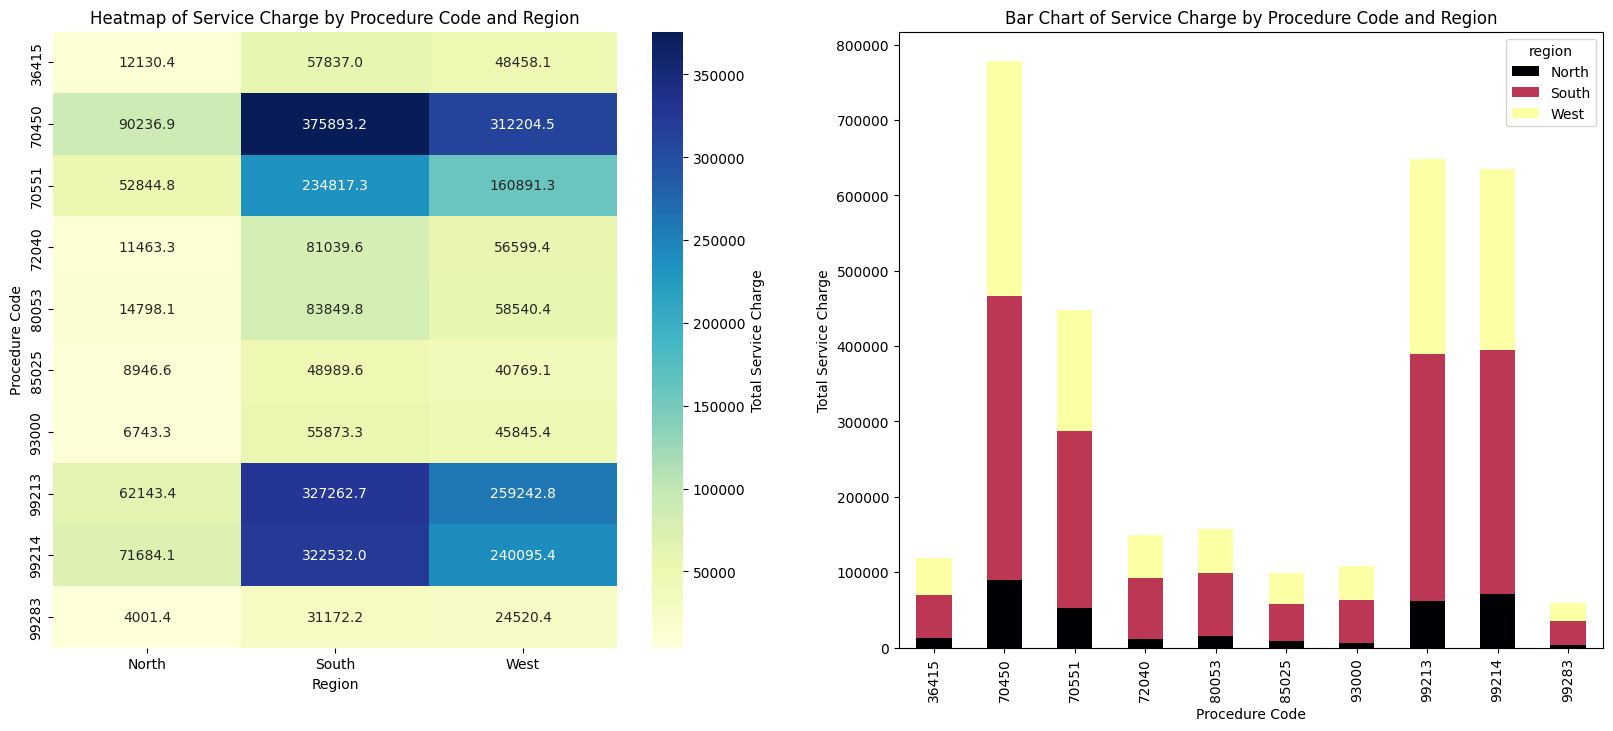

In [12]:
# TODO: Create heatmap from pivot table
# TODO: Customize colors and styling
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    cbar_kws={"label": "Total Service Charge"},
    ax=axes[0],
)

# TODO: Add appropriate titles and labels
axes[0].set_title("Heatmap of Service Charge by Procedure Code and Region")
axes[0].set_xlabel("Region")
axes[0].set_ylabel("Procedure Code")

# TODO: Create bar chart from pivot table
# TODO: Customize colors and styling
pivot_table.plot(kind="bar", stacked=True, colormap="inferno", ax=axes[1])

# TODO: Add appropriate titles and labels
axes[1].set_title("Bar Chart of Service Charge by Procedure Code and Region")
axes[1].set_xlabel("Procedure Code")
axes[1].set_ylabel("Total Service Charge")

# TODO: Save the plot as 'output/q3_pivot_visualization.png'
plt.savefig("output/q3_pivot_visualization.png", dpi=300, bbox_inches="tight")

## Submission Checklist

Before submitting, verify you've created:

- [ ] `output/q1_groupby_analysis.csv` - Basic groupby analysis
- [ ] `output/q1_aggregation_report.txt` - Aggregation report
- [ ] `output/q2_filter_analysis.csv` - Filter operations analysis
- [ ] `output/q2_hierarchical_analysis.csv` - Hierarchical analysis
- [ ] `output/q2_performance_report.txt` - Performance report
- [ ] `output/q3_pivot_analysis.csv` - Pivot table analysis
- [ ] `output/q3_crosstab_analysis.csv` - Cross-tabulation analysis
- [ ] `output/q3_pivot_visualization.png` - Pivot visualization

## Key Learning Objectives

- Master the split-apply-combine paradigm
- Apply aggregation functions and transformations
- Create pivot tables for multi-dimensional analysis
- Apply advanced groupby techniques